In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
import seaborn as sb
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [6]:
# Create spark session
spark = (SparkSession.builder.config("spark.driver.memory","4g").config("spark.driver.maxResultSize", "4g").getOrCreate())


In [7]:
# Create dataframe from the csv
df = spark.read.csv(path='/content/drive/MyDrive/BDA/charts.csv', inferSchema=True, header=True)

In [8]:
# Convert the numeric and date datatype to Spark supported datatypes
df = df.withColumn("rank", f.col("rank").cast(t.LongType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))
df_top200 = df.filter(f.col("chart") == "top200")
df_viral50 = df.filter(f.col("chart") == "viral50")

In [9]:
# Using Spark SQL lib, create table to access spark methods
df.registerTempTable("spotifycharts")


/usr/local/lib/python3.9/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [10]:
def wordcloud_graph(counts):
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='white', 
                   prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate_from_frequencies(counts)
    # cloud = wc.generate(str(counts))
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [11]:
# Total entries in top200. Total datapoints 26,173,514
total = spark.sql('''
SELECT COUNT(*) n
FROM spotifycharts 
WHERE chart = 'top200';
''').toPandas()
total.head(10)

,n
0,20318183


In [12]:
# Get top 10 artists based on the number of their occurrence in top200 over the period 2017-2021
top10 = spark.sql('''
SELECT artist, count(artist) count 
FROM spotifycharts 
WHERE chart='top200' 
GROUP BY artist 
ORDER BY count desc;
''').toPandas().head(10)
top10

,artist,count
0,Ed Sheeran,366026
1,Billie Eilish,230007
2,Post Malone,196620
3,Bad Bunny,187425
4,Ariana Grande,174403
5,Dua Lipa,173678
6,Drake,156845
7,Imagine Dragons,144081
8,XXXTENTACION,142029
9,The Weeknd,133967


In [13]:
# Visualize using wordcloud
counts = spark.sql('''
SELECT artist 
FROM spotifycharts 
WHERE chart='top200';
''').toPandas()
# counts.head(10)


In [14]:
counts.shape
counts = counts['artist'].value_counts()
# counts = counts.value_counts()

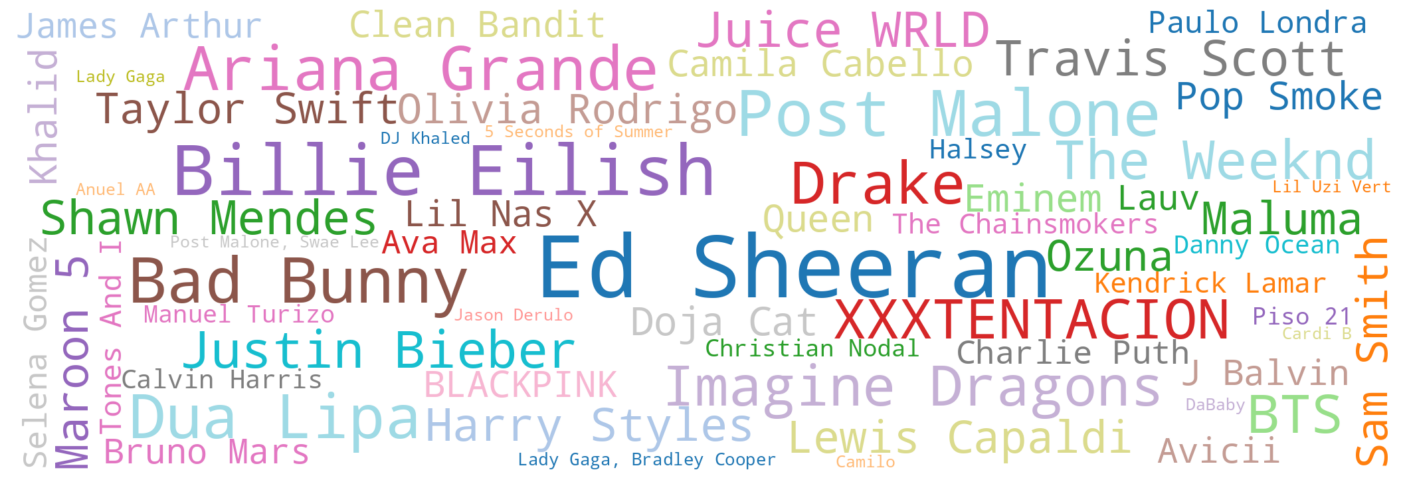

In [15]:
wordcloud_graph(counts)

In [16]:
# Top 10 songs of all time based on the streams
topstreams = spark.sql('''
SELECT title, SUM(streams) streams 
FROM spotifycharts 
WHERE streams IS NOT NULL 
GROUP BY title 
ORDER BY streams DESC 
LIMIT 10;''').toPandas()
topstreams.head(10)

,title,streams
0,Shape of You,5245740051
1,Blinding Lights,5183476311
2,Dance Monkey,4553470909
3,Someone You Loved,4000277679
4,Sunflower - Spider-Man: Into the Spider-Verse,3786210858
5,Señorita,3586040800
6,bad guy,3468670333
7,Don't Start Now,3256305407
8,Lucid Dreams,3184855442
9,Happier,3177045540


In [17]:
# The number of times the songs appreared in top200
top200 = spark.sql('''
SELECT title, artist, count(title) AS count 
FROM spotifycharts 
WHERE chart = 'top200' 
GROUP BY title, artist 
ORDER BY count DESC;
''').toPandas()
top200.head(10)

,title,artist,count
0,Shape of You,Ed Sheeran,65262
1,Believer,Imagine Dragons,58191
2,Perfect,Ed Sheeran,52392
3,Someone You Loved,Lewis Capaldi,50975
4,Blinding Lights,The Weeknd,47747
5,Dance Monkey,Tones And I,43263
6,Shallow,"Lady Gaga, Bradley Cooper",41109
7,Don't Start Now,Dua Lipa,40240
8,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",39645
9,bad guy,Billie Eilish,39470


In [18]:
# Rank 1 songs and the number of days in the position
rank1 = spark.sql('''
SELECT title, artist, MIN(rank) rank, count(rank) count 
FROM spotifycharts 
WHERE chart = 'top200' 
AND rank == 1 
GROUP BY title, artist
ORDER BY count DESC;
''').toPandas()
rank1.head(20)

,title,artist,rank,count
0,Shape of You,Ed Sheeran,1,3840
1,Dance Monkey,Tones And I,1,2793
2,Señorita,"Shawn Mendes, Camila Cabello",1,2671
3,Despacito - Remix,"Luis Fonsi, Daddy Yankee, Justin Bieber",1,2369
4,STAY (with Justin Bieber),The Kid LAROI,1,1820
5,rockstar,"Post Malone, 21 Savage",1,1801
6,DÁKITI,"Bad Bunny, Jhay Cortez",1,1769
7,Despacito (Featuring Daddy Yankee),Luis Fonsi,1,1651
8,Tusa,"KAROL G, Nicki Minaj",1,1511
9,Blinding Lights,The Weeknd,1,1365


In [19]:
# Top 20 Artists who were at Rank 1 
topartists = spark.sql('''
SELECT artist, count(artist) Rank1Count 
FROM spotifycharts 
WHERE chart='top200' 
AND rank = 1
GROUP BY artist 
ORDER BY Rank1Count desc; 
''').toPandas()
topartists.head(20)

,artist,Rank1Count
0,Ed Sheeran,4810
1,Ariana Grande,2896
2,Drake,2885
3,Tones And I,2793
4,"Shawn Mendes, Camila Cabello",2671
5,"Luis Fonsi, Daddy Yankee, Justin Bieber",2369
6,Bad Bunny,2240
7,Maluma,2212
8,Olivia Rodrigo,1955
9,The Kid LAROI,1888


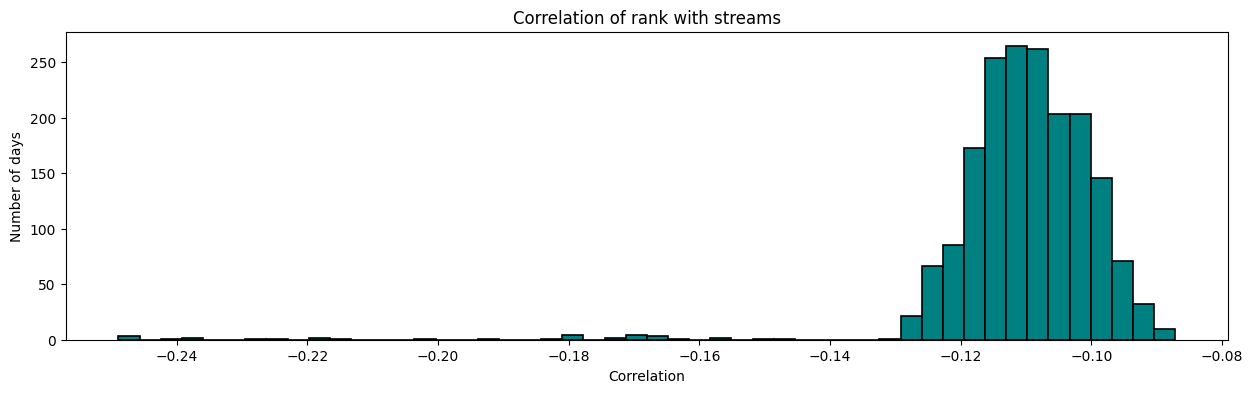

In [21]:
# is rank and streams correlated?
top50 = df_top200[(df_top200['rank'] <= 50)].toPandas()
correlations = [d['streams'].corr(d['rank']) for date, d in top50.groupby('date')]

plt.figure(figsize=(15,4))
plt.hist(correlations, bins=50, color ='teal', edgecolor='black', linewidth=1.2)
plt.xlabel('Correlation')
plt.ylabel('Number of days')
plt.title('Correlation of rank with streams')
plt.show()

We expect that whenever rank is small number (like 1st rank) the number of streams will be high. So, they must be inversely correlated.<br>
The histogram shows that the rank and the number of streams are weakly correlated.